#**Auction Model**



********************************************

This report presents explores auction data and develops a model to predict the auction pricies. We consider the following topics:
* Data Cleaning
* Data Exploration
* Model Selection and Tuning
* Model Evaluation
* Model Improvement Ideas
* Model Implementation: Practical Challenges




********************************************

Author: Samuel Ayo

Date Created: 15/12/2025




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install packages
%%capture
try:
  import kaleido
except:
  %pip install -U kaleido #xgboost lightgbm shap

Read data and display sample

In [ ]:
#load file
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#read data
file_path = '/content/drive/My Drive/datasets/20251208 BCA Cinch Data Scientist Data Scientist Case Study Data.csv'
df = pd.read_csv(file_path)


Display a sample of the data

In [ ]:
styled_df = df.head(10)\
                            .style.set_properties(**{'background-color': 'lightyellow', 'color': 'black', 'border-color': 'black'})\
                            .set_table_styles([{'selector': 'th', 'props': [('background-color', '#40B0A6')]},
                                               {'selector': 'td', 'props': [('border', '1px solid black')]},
                                               {'selector': 'th', 'props': [('border', '1px solid black')]}]
                    )
styled_df


,sale_price,make,model,derivative,body_type,fuel_type,retail_price_when_new,odometer_miles,registration_date,sale_date,cosmetic_grade,mechanical_failure,accident_damaged,insurance_writeoff,taxi,service_history_available,number_of_registered_keepers,colour,odometer_validated
0,299.000000,VOLVO,V70,D5 SE,ESTATE,DIESEL,25945,220532,2007-05-20,2025-11-10,3,No,No,No,No,Yes,4.000000,GOLD,Yes
1,5805.000000,RENAULT,CLIO,DCI 90 DYNAMIQUE,HATCHBACK,DIESEL,15540,22861,2017-06-30,2025-11-01,3,No,No,No,No,Yes,2.000000,CREAM,Yes
2,100.000000,HYUNDAI,GETZ,GSI,HATCHBACK,PETROL,7352,185358,2008-09-29,2025-03-09,5,No,No,No,No,Yes,2.000000,SILVER,Yes
3,8763.000000,AUDI,A4,TDI ULTRA 150 SE,SALOON,DIESEL,29095,60306,2018-06-21,2024-11-21,5,No,No,No,No,Yes,3.000000,BLACK,Yes
4,19396.000000,AUDI,Q3,TDI 184 QUATTRO BLACK ED.S-T,STATIONWAGON,DIESEL,37345,48410,2019-09-26,2025-07-13,2,No,No,No,No,Yes,3.000000,GREEN,Yes
5,10584.000000,VOLKSWAGEN,GOLF,TDI 184 GTD,HATCHBACK,DIESEL,26750,64505,2018-03-29,2024-12-09,4,No,No,No,No,Yes,2.000000,BLACK,Yes
6,4611.000000,NISSAN,JUKE,N-TEC,HATCHBACK,PETROL,16015,65488,2016-06-13,2025-02-15,4,No,No,No,No,Yes,3.000000,BLACK,Yes
7,8040.000000,PEUGEOT,3008,BLUEHDI 120 ACTIVE EAT6,MPV,DIESEL,22090,31699,2017-11-10,2024-11-20,2,No,No,No,No,Yes,3.000000,GREY,Yes
8,9898.000000,MERCEDES-BENZ,A180 D,SPORT DCT,HATCHBACK,DIESEL,25545,32650,2019-05-31,2025-09-25,5,No,No,No,No,Yes,3.000000,RED,Yes
9,957.000000,VAUXHALL,MERIVA,T 16V 120 S,MPV,PETROL,16535,123453,2012-06-30,2025-01-26,2,No,No,No,No,Yes,3.000000,SILVER,Yes


Plot some categorical columns

From the plots we can see that loss code and Loss_description have only one value (redundant). So add them to dropped columns


Get data types

In [ ]:
df.dtypes#.head(15)

,0
sale_price,float64
make,object
model,object
derivative,object
body_type,object
fuel_type,object
retail_price_when_new,int64
odometer_miles,int64
registration_date,object
sale_date,object


Data types are not what we expected. This is due to a number of issues:
* Strings like '-' (filler text) in numeric/boolean columns
* Money symbols and comma in financial columns like Incurred

Edit data types, especially TP columns converted to numeric

# **Data Cleaning**



* We have to remove superflous characters like £, -, spaces etc
* Furthermore, we ensure variable are cast to their correct types: numeric, categoricals etc

In [ ]:
#get numerical and categorical
num_cols = df.select_dtypes(include=np.number).columns.tolist()
bool_cols =  ["mechanical_failure",	"accident_damaged",	"insurance_writeoff",	"taxi",	"service_history_available", "odometer_validated"]
date_cols = ["registration_date", "sale_date"]
cat_cols = [x for x in df.columns if x not in  num_cols+ date_cols]
print("num_cols: ", num_cols)
print("date_cols: ", date_cols)
print("cat_cols: ", cat_cols)


num_cols:  ['sale_price', 'retail_price_when_new', 'odometer_miles', 'number_of_registered_keepers']
date_cols:  ['registration_date', 'sale_date']
cat_cols:  ['make', 'model', 'derivative', 'body_type', 'fuel_type', 'cosmetic_grade', 'mechanical_failure', 'accident_damaged', 'insurance_writeoff', 'taxi', 'service_history_available', 'colour', 'odometer_validated']


In [ ]:

#convert yes/no to numerical flags (0/1)
for col in bool_cols:
  df[col] = df[col].str.lower().replace('no', '0').replace('yes', '1')

#convert date column to datetime format
for col in date_cols:
  df[col] = pd.to_datetime(df[col])

#convert numeric columns to numeric format
for col in num_cols:
  df[col] = df[col].astype('float')


#Feature engineering and selection


In [ ]:
#we can engineer features e.g. get day of the week
df['sale_day_of_week'] = df['sale_date'].dt.day_of_week
num_cols.append('sale_day_of_week')
df['sale_month'] = df['sale_date'].dt.month
num_cols.append('sale_month')
df['sale_year'] = df['sale_date'].dt.year
num_cols.append('sale_year')

# car age
df['car_age'] = (df['sale_date'] - df['registration_date']).dt.days / 365.4 # Average days in a month
num_cols.append('car_age')
#mileage greater than 100000
df['long_mileage'] = (df['odometer_miles'] > 100000).astype(int)
num_cols.append('long_mileage')

In [ ]:
print(num_cols)

['sale_price', 'retail_price_when_new', 'odometer_miles', 'number_of_registered_keepers', 'sale_day_of_week', 'sale_month', 'sale_year', 'car_age', 'long_mileage']


Check that relevant columns don't have too few or too many categories. Else too many columns (slows model training) or redundant columns


#**Data Exploration**

In [ ]:
from plotly.subplots import make_subplots
import plotly.io as pio
import kaleido


drop_cols = []#'derivative']
cat_cols = [x for x in cat_cols if x not in drop_cols] # except derivative
cols = cat_cols +['long_mileage', 'sale_day_of_week', 'sale_month']

pio.templates.default = "plotly" #plot theme
fig = make_subplots(rows=len(cols)//2+1, cols=2, subplot_titles=cols) # Add subplot titles

for i, col in enumerate(cols):
    row = i // 2 + 1
    col_num = i % 2 + 1
    col_grp = df.groupby(by=[col]).size().reset_index(name="count").sort_values(by='count', ascending=False).head(10)
    fig.add_trace(go.Bar(x=col_grp[col], y=col_grp["count"]), row=row, col=col_num)

fig.update_layout(height=2000, width=1200, title_text="Some Categorical Variables")
fig.show()
#img_bytes = fig.to_image(format="png");
#from IPython.display import Image
#Image(img_bytes)

In [ ]:
# summary stats for numeric
df[num_cols].describe()

,sale_price,retail_price_when_new,odometer_miles,number_of_registered_keepers,sale_day_of_week,sale_month,sale_year,car_age,long_mileage
count,177050.000000,177050.000000,177050.000000,176491.000000,177050.000000,177050.000000,177050.000000,177050.000000,177050.000000
mean,8650.850404,24767.677741,69581.536639,2.693401,3.468647,6.257729,2024.887009,8.888847,0.211748
std,9369.113749,14173.838521,38908.092716,1.628266,2.010892,3.405070,0.316582,4.524831,0.408548
min,96.000000,4830.000000,102.000000,1.000000,0.000000,1.000000,2024.000000,-0.008210,0.000000
25%,1965.000000,15105.000000,39120.250000,2.000000,2.000000,3.000000,2025.000000,5.016420,0.000000
50%,5446.000000,21530.000000,65803.000000,2.000000,4.000000,6.000000,2025.000000,8.505747,0.000000
75%,12530.750000,30420.000000,94668.000000,3.000000,5.000000,9.000000,2025.000000,12.145594,0.000000
max,197076.000000,252000.000000,249486.000000,28.000000,6.000000,12.000000,2025.000000,20.073892,1.000000


Plot distributions of numerical columns

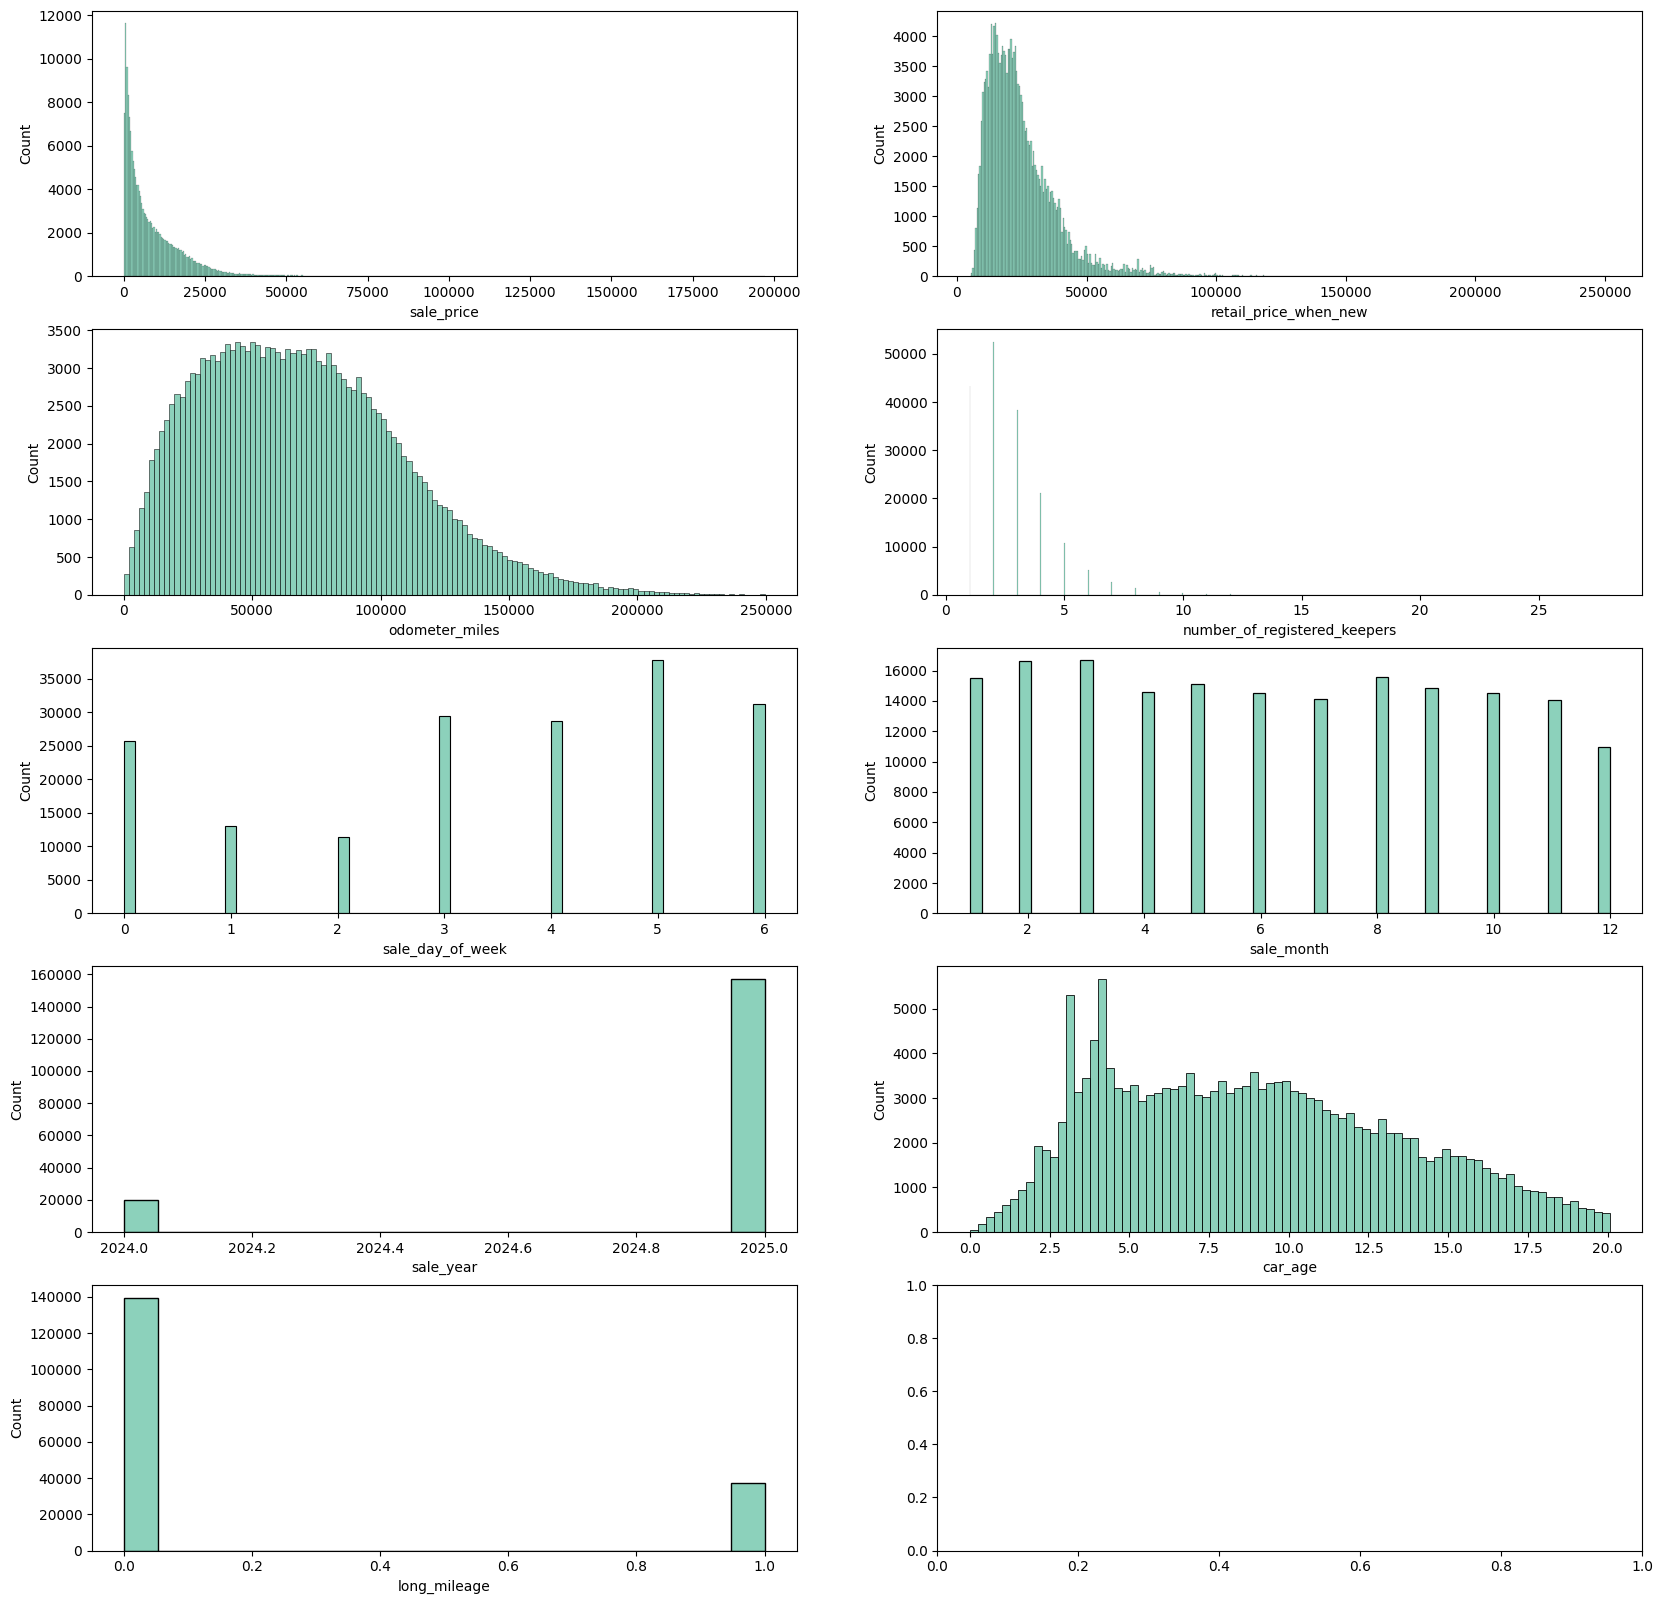

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

#plot some numerical columns
plot_cols = num_cols
fig, axes = plt.subplots(round(len(plot_cols)/2)+1, 2, figsize=(20, 20))
for i in range(len(plot_cols)):
  sns.histplot(ax=axes[i//2, i%2], data=df, x=plot_cols[i])


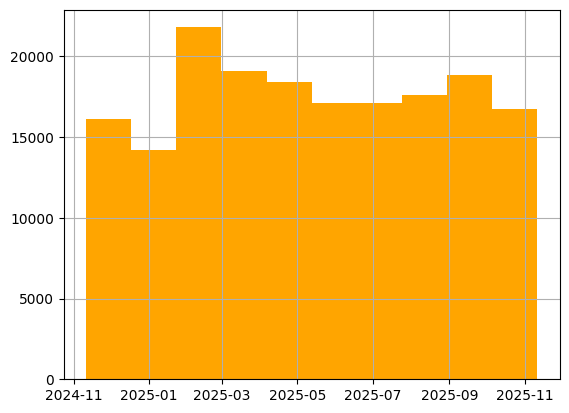

In [ ]:
#focussing on sale date
this_plot = df['sale_date'].hist(color='orange')
plt.title = "sale_date"


Some variables have highly skewed distributions (from the above). Such columns can be capped. Also, the target variable has a gamma distribution

Looking at the columns, we can see that most columns have good correlation, so we keep them

top correlation with capped incurred


<Axes: ylabel='index'>

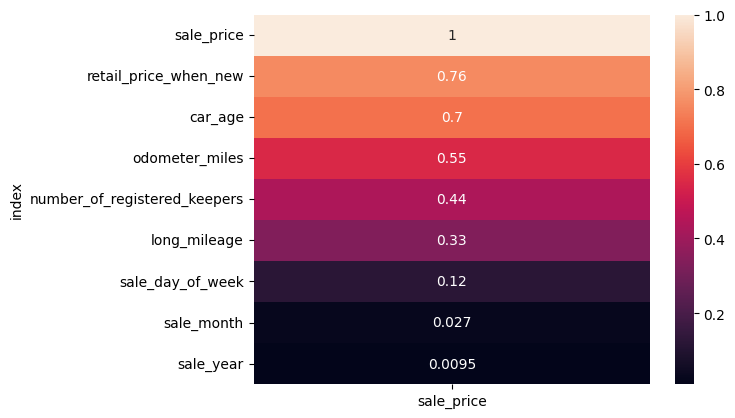

In [ ]:
target = 'sale_price'
corr_df = df[num_cols].corr()

corr_target = corr_df[target].abs().reset_index().sort_values(by=target, ascending=False)
print("top correlation with capped incurred")
sns.heatmap(corr_target.head(20).set_index('index'), annot=True)

Lowest 10 absolute correlation with capped incurred 


<Axes: ylabel='index'>

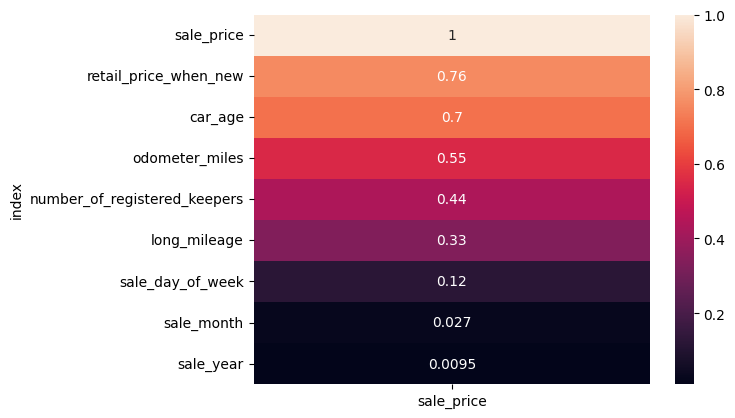

In [ ]:
print("Lowest 10 absolute correlation with capped incurred ")
sns.heatmap(corr_target.tail(10).set_index('index'), annot=True)

In [ ]:
#remove columns not used
drop_cols=[]
num_cols = [x for x in num_cols if x not in drop_cols]
num_cols.remove(target)

Also check if variables are too correlated with each other, pairwise

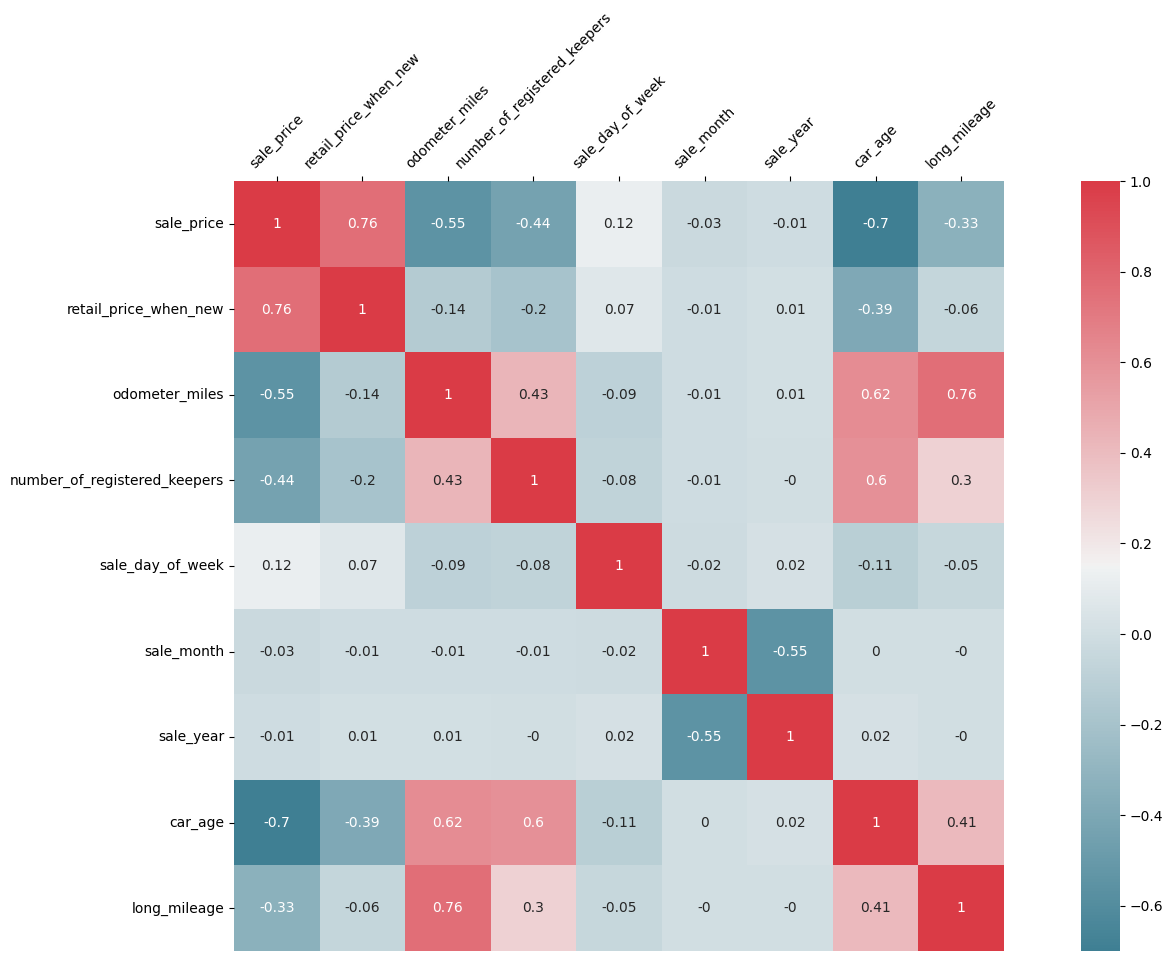

In [ ]:

plt.figure(figsize=(20,10))

ax = sns.heatmap(corr_df.iloc[0:15, 0:15].round(2), annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, )

ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

for item in ax.get_xticklabels():
    item.set_rotation(45)



In [ ]:
print('correlation matrix')
display(corr_df.head(10))

correlation matrix


,sale_price,retail_price_when_new,odometer_miles,number_of_registered_keepers,sale_day_of_week,sale_month,sale_year,car_age,long_mileage
sale_price,1.000000,0.759617,-0.549099,-0.435103,0.119936,-0.026612,-0.009517,-0.702558,-0.333310
retail_price_when_new,0.759617,1.000000,-0.137962,-0.200169,0.071439,-0.006945,0.009979,-0.387949,-0.062297
odometer_miles,-0.549099,-0.137962,1.000000,0.430471,-0.085253,-0.005024,0.007933,0.616336,0.761502
number_of_registered_keepers,-0.435103,-0.200169,0.430471,1.000000,-0.078362,-0.010528,-0.002067,0.598779,0.297683
sale_day_of_week,0.119936,0.071439,-0.085253,-0.078362,1.000000,-0.022316,0.016443,-0.112208,-0.048287
sale_month,-0.026612,-0.006945,-0.005024,-0.010528,-0.022316,1.000000,-0.554408,0.004230,-0.002474
sale_year,-0.009517,0.009979,0.007933,-0.002067,0.016443,-0.554408,1.000000,0.020274,-0.000436
car_age,-0.702558,-0.387949,0.616336,0.598779,-0.112208,0.004230,0.020274,1.000000,0.408937
long_mileage,-0.333310,-0.062297,0.761502,0.297683,-0.048287,-0.002474,-0.000436,0.408937,1.000000


# Train test split




In [ ]:
from sklearn.model_selection import train_test_split

#ensure time is respected for train/test

#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.4, random_state=12)# stratify=df['nonzero'])

df = df.set_index('sale_date').sort_index()
split_point = int(len(df) * 0.7)
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

y_train = train_data.pop(target)
y_test = test_data.pop(target)
X_test = test_data[num_cols+cat_cols]
X_train = train_data[num_cols+cat_cols]

print("all input features: ", [num_cols+cat_cols])



all input features:  [['retail_price_when_new', 'odometer_miles', 'number_of_registered_keepers', 'sale_day_of_week', 'sale_month', 'sale_year', 'car_age', 'long_mileage', 'make', 'model', 'derivative', 'body_type', 'fuel_type', 'cosmetic_grade', 'mechanical_failure', 'accident_damaged', 'insurance_writeoff', 'taxi', 'service_history_available', 'colour', 'odometer_validated']]


In [ ]:
print(df.columns)

Index(['sale_price', 'make', 'model', 'derivative', 'body_type', 'fuel_type',
       'retail_price_when_new', 'odometer_miles', 'registration_date',
       'cosmetic_grade', 'mechanical_failure', 'accident_damaged',
       'insurance_writeoff', 'taxi', 'service_history_available',
       'number_of_registered_keepers', 'colour', 'odometer_validated',
       'sale_day_of_week', 'sale_month', 'sale_year', 'car_age',
       'long_mileage'],
      dtype='object')


#Cap values

In [ ]:
common_derivative = df.derivative.value_counts().iloc[0:100].reset_index().derivative.tolist()

X_train['derivative'] = np.where(X_train.derivative.isin(common_derivative), X_train.derivative, 'other')
X_test["derivative"] = np.where(X_test.derivative.isin(common_derivative), X_test.derivative, 'other')


/tmp/ipython-input-343051621.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-343051621.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Clipped owners to:  8


/tmp/ipython-input-2199814043.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2199814043.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



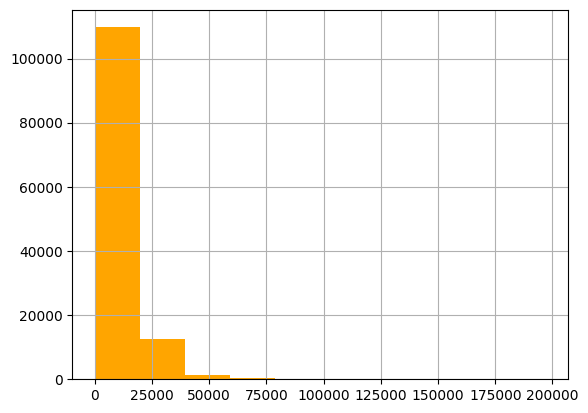

In [ ]:
#upper bound to 3 standard deviations
import math
y_train.hist(color='orange')
#capped_price = 80000
#y_train = y_train.clip(upper=capped_price)
#print('Clipped price to: ', capped_price)

#cap number of owners
upper_bound2 = math.ceil(X_train["number_of_registered_keepers"].mean()+3*X_train["number_of_registered_keepers"].std())
X_train["number_of_registered_keepers"] = X_train["number_of_registered_keepers"].clip(upper=upper_bound2)
X_test["number_of_registered_keepers"] = X_test["number_of_registered_keepers"].clip(upper=upper_bound2)

print('Clipped owners to: ', upper_bound2)

#Data Transform

Here we scale the numeric data and one-hot encode the categoricals. We also impute any missing values with median (good for skewed data distributions)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


#preprocess data

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

X_train_prep = pd.DataFrame(preprocessor.fit_transform(X_train[num_cols+cat_cols]).toarray(),
                            columns = preprocessor.get_feature_names_out())
X_test_prep = pd.DataFrame(preprocessor.transform(X_test[num_cols+cat_cols]).toarray(),
                            columns = preprocessor.get_feature_names_out())

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [1, 11] during transform. These unknown categories will be encoded as all zeros



In [ ]:
display(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['retail_price_when_new', 'odometer_miles',
                                  'number_of_registered_keepers',
                                  'sale_day_of_week', 'sale_month', 'sale_year',
                                  'car_age', 'long_mileage']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['make', 'model', 'derivative', 'body_type',
                                  'fuel_type', 'cosmetic_grade',
                                  'mechanical_failure', 'accident_damaged',
                                  'insurance_writeoff', 'taxi',
                                  'service_history_available', 'colour',
                                  'odometer_validated'])])

#**Model specification and justification**

Here we tentatively choose Gradient Boosting Machines (GBM) models as:
* they have high performance on the tabular data.
* Also you can easily specify the target distribution like gamma, poisson etc
* LighGBM particularly has a good trade off of speed and performance
* We test a number of models from different model groups to confirm our hypothesis

Distribution of target


Text(0, 0.5, 'frequency')

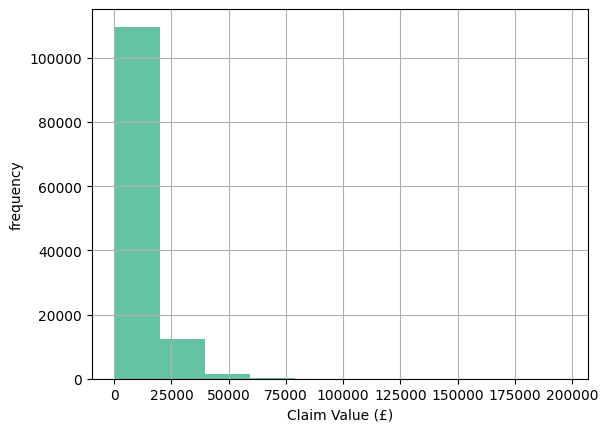

In [ ]:
print('Distribution of target')
sns.set_palette('Set2')
y_plot = y_train.hist()
y_plot.set_xlabel('Claim Value (£)')
y_plot.set_ylabel('frequency')

lr
Mean prediction:  8756.879532030132
Mean (actual):  8093.075758716771
std prediction:  9074.240284248997
std (actual):  8806.40346019769

 
Histogram of Predicted Claims
lighgbm
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 123934, number of used features: 758
[LightGBM] [Info] Start training from score 8889.903110
Mean prediction:  8632.44369119811
Mean (actual):  8093.075758716771
std prediction:  9422.097517622407
std (actual):  8806.40346019769

 
Histogram of Predicted Claims


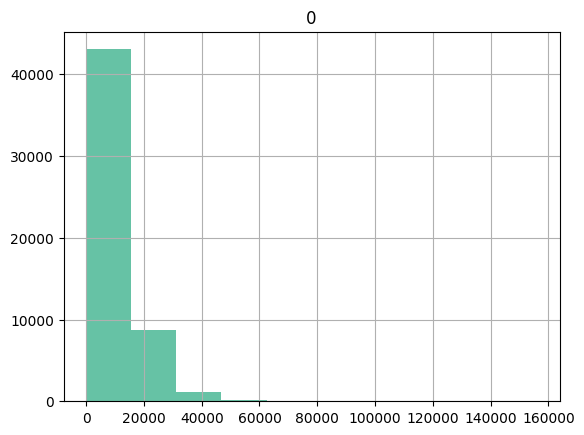

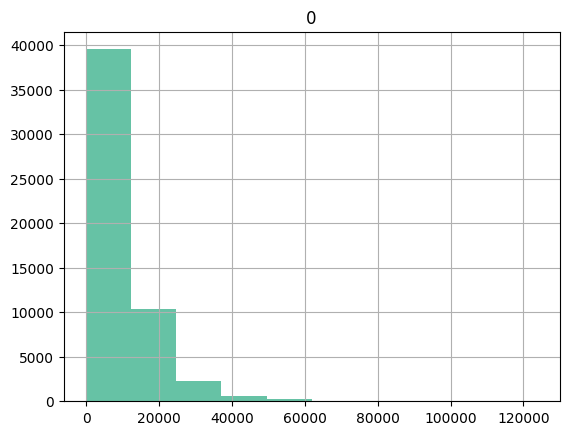

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_poisson_deviance,  mean_gamma_deviance, r2_score,mean_absolute_error, mean_absolute_percentage_error
import lightgbm as lgb
import re
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

lr = LinearRegression()

lg = lgb.LGBMRegressor()
models = {'lr': lr, 'lighgbm': lg}#'mlp': mlp,
mgd = {}
rmse = {}
mae = {}
r2 = {}
eps = 0
y_train = y_train + eps # greater than zero for gamma

for model_name, model in models.items():
  print(model_name)
  model.fit(X_train_prep, y_train)
  y_pred = model.predict(X_test_prep).clip(min=0)
  print("Mean prediction: ", y_pred.mean() )
  print("Mean (actual): ", y_test.mean() )
  print("std prediction: ", y_pred.std() )
  print("std (actual): ", y_test.std())
  print("\n \nHistogram of Predicted Claims")
  y_plot = pd.DataFrame(y_pred).hist()
  # Calculate the mean Poisson deviance
  mgd[model_name] = mean_absolute_percentage_error(y_test + eps, y_pred + eps)
  rmse[model_name] = root_mean_squared_error(y_test, y_pred)
  mae[model_name] = mean_absolute_error(y_test, y_pred)
  r2[model_name] = r2_score(y_test, y_pred)


In [ ]:
display(pd.DataFrame({'model': mgd.keys(), 'MAPE': mgd.values(),
                      'RMSE': rmse.values(), 'MAE': mae.values(),
                      'R2': r2.values()}).round(1))


,model,MAPE,RMSE,MAE,R2
0,lr,0.4,2542.5,1552.3,0.9
1,lighgbm,0.2,2006.2,1064.1,0.9


MGD is mean gamma distribution


Lightgbm had better performance on most metrics. So it would be selected for further tuning





# Model Tuning

* It's a small dataset, so we will use grid search in small time (search each combination of parameter).
* For quicker tuning or large search space, we could   use hyperopt/bayesian or randomised search
- We also used cross-validation (splits) to ensure the training results are more representative

In [ ]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

ts_cv = TimeSeriesSplit(
    n_splits=5,
)


In [ ]:
print(len(X_train))

123934


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'num_leaves': [7, 15, 30, 60, 120],
              'max_depth': [3, 4, 7, 10],
              'min_child_weight': [0.01, 0.1],
              'n_estimators': [20, 50, 100, 200] }
clf = RandomizedSearchCV(lg, parameters, scoring='neg_root_mean_squared_error', n_iter=15, cv=ts_cv)
clf.fit(X_train_prep, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 20659, number of used features: 397
[LightGBM] [Info] Start training from score 8892.185295
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1799
[LightGBM] [Info] Number of data points in the train set: 41314, number of used features: 511
[LightGBM] [Info] Start training from score 8897.331002
[LightGBM] [Warning]

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(), n_iter=15,
                   param_distributions={'max_depth': [3, 4, 7, 10],
                                        'min_child_weight': [0.01, 0.1],
                                        'n_estimators': [20, 50, 100, 200],
                                        'num_leaves': [7, 15, 30, 60, 120]},
                   scoring='neg_root_mean_squared_error')

In [ ]:
display(clf.best_estimator_)

LGBMRegressor(max_depth=10, min_child_weight=0.1, n_estimators=200,
              num_leaves=30)

#**Model Accuracy & Diagnostics**

## General metrics

In [ ]:

print('Best parameter: ', clf.best_params_)
print('Best score: ', clf.best_score_)

def metrics_values(clf, X_test_prep, y_test, name='model'):
  y_pred = clf.predict(X_test_prep)
  # Calculate the mean Poisson deviance
  mgd[name] = mean_absolute_percentage_error(y_test + eps, y_pred + eps)
  rmse[name] = root_mean_squared_error(y_test, y_pred)
  mae[name] = mean_absolute_error(y_test, y_pred)
  r2[name] = r2_score(y_test, y_pred)
  results = pd.DataFrame({'model': mgd.keys(), 'MAPE': mgd.values(),
                        'RMSE': rmse.values(), 'MAE': mae.values(),
                        'R2': r2.values()}).round(1)
  return results
#get results for tuned model
metrics_values(clf, X_test_prep, y_test, name='Tuned_LightGBM_test')
#also get it for uncapped target (Incurred)
metrics_df = metrics_values(clf, X_train_prep, y_train, name='Tuned_LightGBM_train')

display(metrics_df)


Best parameter:  {'num_leaves': 30, 'n_estimators': 200, 'min_child_weight': 0.1, 'max_depth': 10}
Best score:  -1640.0887412590193


,model,MAPE,RMSE,MAE,R2
0,lr,0.4,2542.5,1552.3,0.9
1,lighgbm,0.2,2006.2,1064.1,0.9
2,Tuned_LightGBM_test,0.2,1967.7,1010.2,1.0
3,Tuned_LightGBM_train,0.2,1282.7,771.1,1.0


* As expected tuning improved model performance.
* Also, using the capped claim values improved the model metrics compared with uncapped target
* Test metrics of MDG not too far from train metrics, implying model is not overfitting

##Feature Importance

<Axes: xlabel='Importance', ylabel='Feature'>

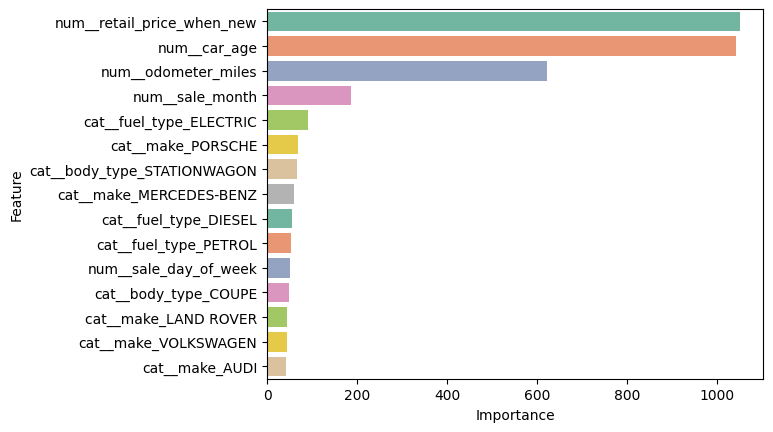

In [ ]:
best_model = clf.best_estimator_
importance_df = pd.DataFrame({'Feature': X_train_prep.columns, 'Importance': best_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(data=importance_df.head(15), y= 'Feature', x='Importance', palette="Set2", hue='Feature')

* Engineered feature (sum_tp_cols) came top in feature importance, which is logical because more claim touchpoints likely mean more complexity in the claim and more things for the customer to claim for. Also, it could indicate it was a serious incident
* Feature shows that variables like Inception_to_loss, TP_injury_whiplash, Notification_period, Time_hour, TP_injury are driving the model predictions.

##PDPs

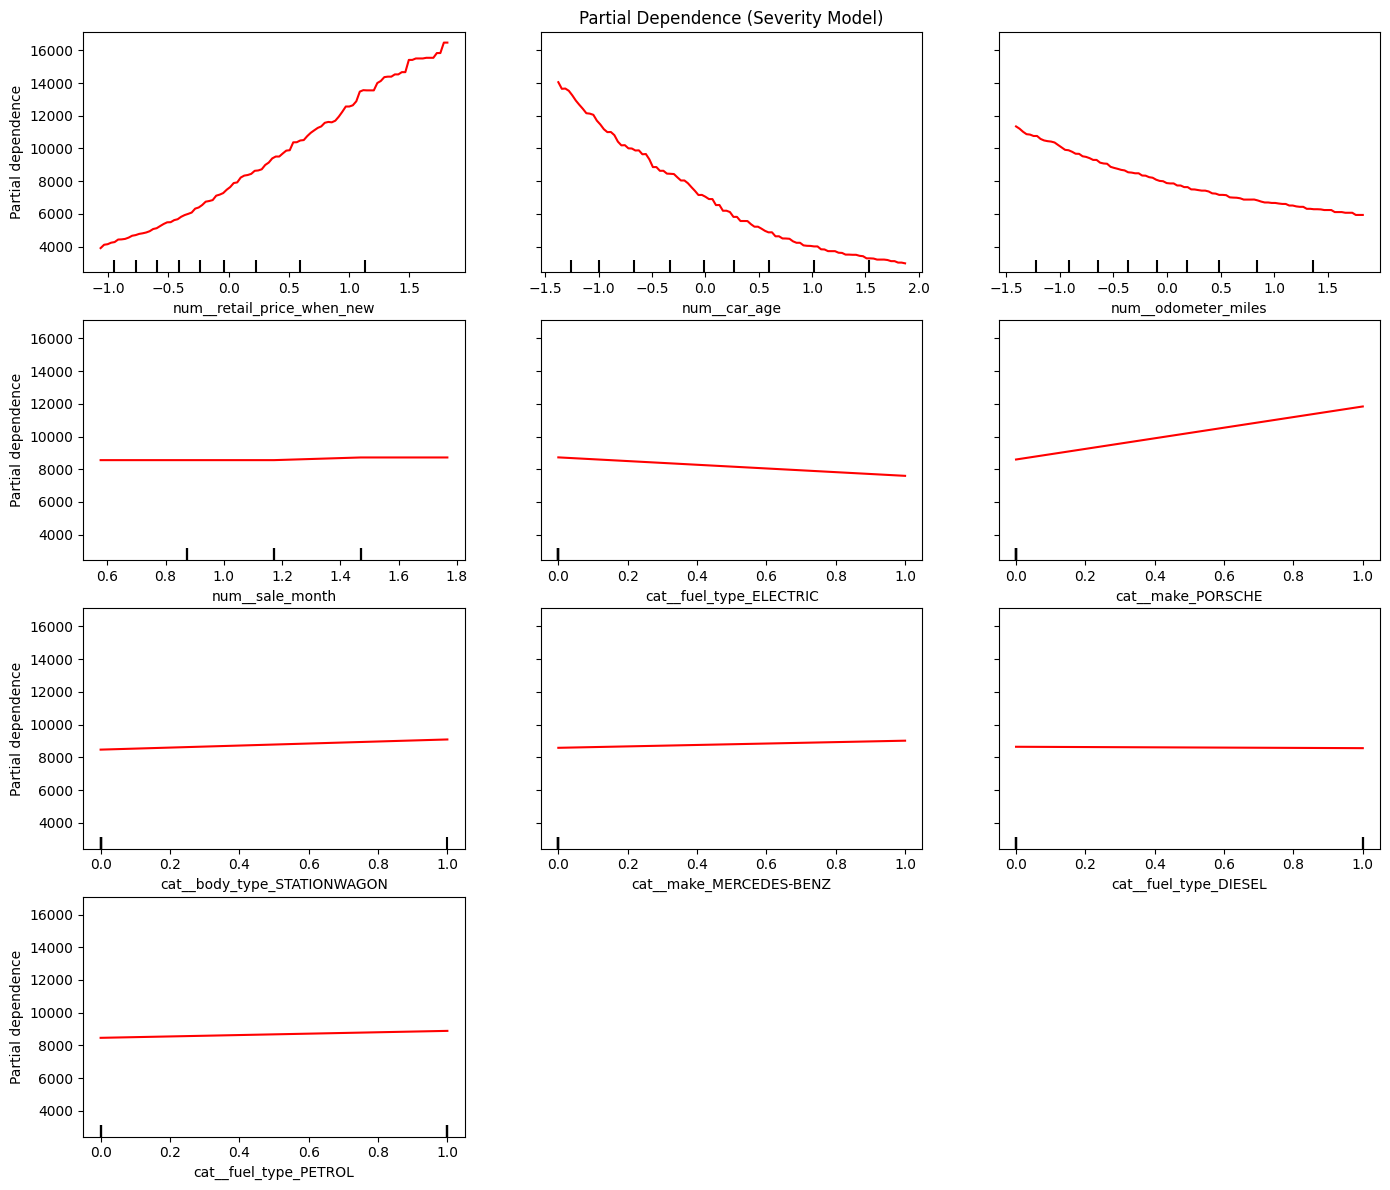

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
sns.set_palette("Set2")
top_features = importance_df.Feature[0:5]
# ['num__Inception_to_loss', 'num__TP_injury_whiplash', 'num__Notification_period', 'num__Time_hour', 'num__TP_injury_traumatic']
fig, ax = plt.subplots(figsize=(14, 12))
ax.set_title("Partial Dependence (Severity Model)")
PartialDependenceDisplay.from_estimator(
    best_model, X_test_prep, top_features, ax=ax, line_kw={"color": "red"}
)
fig.tight_layout()

##SHAP

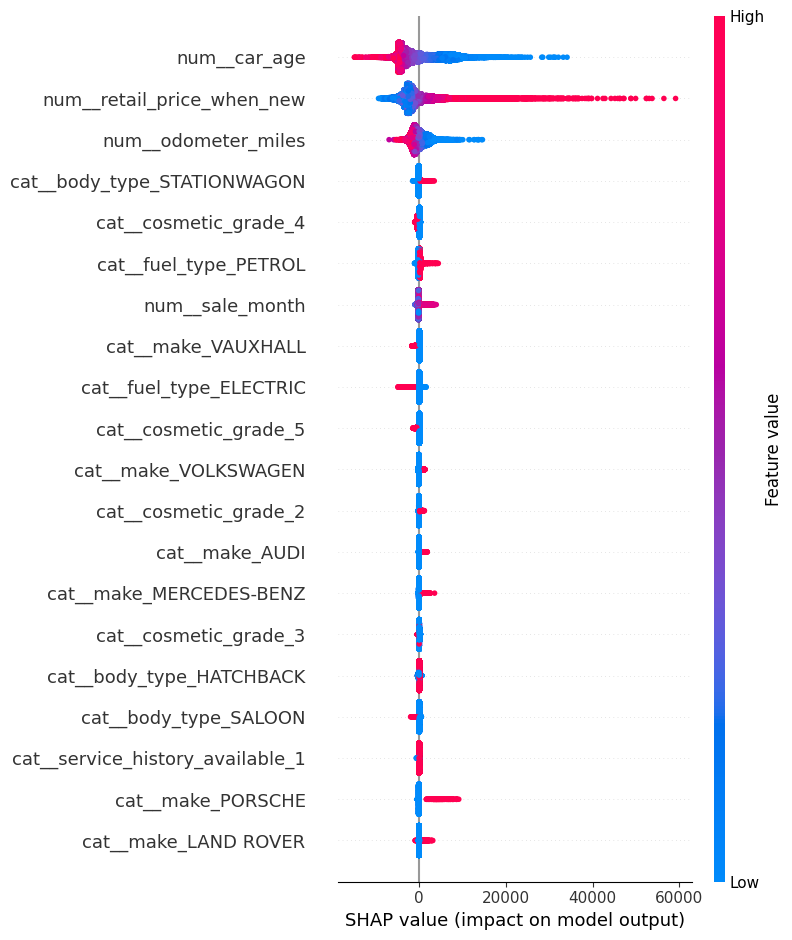

In [ ]:
import shap

explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test_prep)

features = X_test_prep.columns.tolist()

shap.summary_plot(shap_values, X_test_prep, feature_names=features)

SHAP plot arranged in order of importance too. However, we can get more information like if TP_injury was traumatic, then claims cost was higher. Conversely, if third party injury was nk (not_known?), claim cost tends to be lower

## Residuals

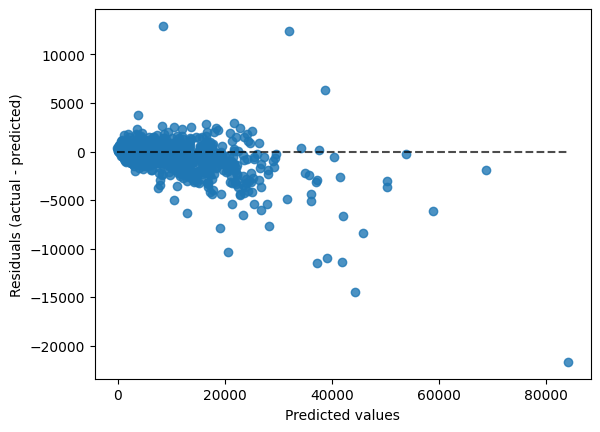

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
disp = PredictionErrorDisplay.from_estimator(best_model, X_test_prep, y_test)


Error appears to be within a band. This could be because we capped the target. Also, errors were around zero, which is a confirmation that the model predicts correctly. Overall, errors are fairly random, which is the expected behaviour

##Lift charts

In [ ]:
# Create a DataFrame with deciles and predicted probabilities

# Create a DataFrame with deciles and predicted probabilities
y_pred_proba = best_model.predict(X_test_prep)
y_pred_proba_df = pd.DataFrame({'predicted_probability': y_pred_proba, 'actual_value': y_test})
y_pred_proba_df = y_pred_proba_df.sort_values(by='predicted_probability', ascending=False)
bin_labels, bins = pd.qcut(y_pred_proba_df['predicted_probability'], 10, labels=False, precision=1, retbins=True)
y_pred_proba_df['decile']= bin_labels
intervals = []
for i in range(len(bins) - 1):
    intervals.append(f"{bins[i].round()} - {bins[i+1].round()}")

decile_stats = y_pred_proba_df.groupby('decile').agg(
    actual_mean=('actual_value', 'mean'),
    pred_mean=('predicted_probability', 'mean'),
    actual_value=('actual_value', 'sum')
).reset_index()
decile_stats ['bins'] = intervals


we plot two lines on the same chart: actual_mean and pred_mean. The x-axis is the bands. In the background of same chart, we plot actual_sum in grey

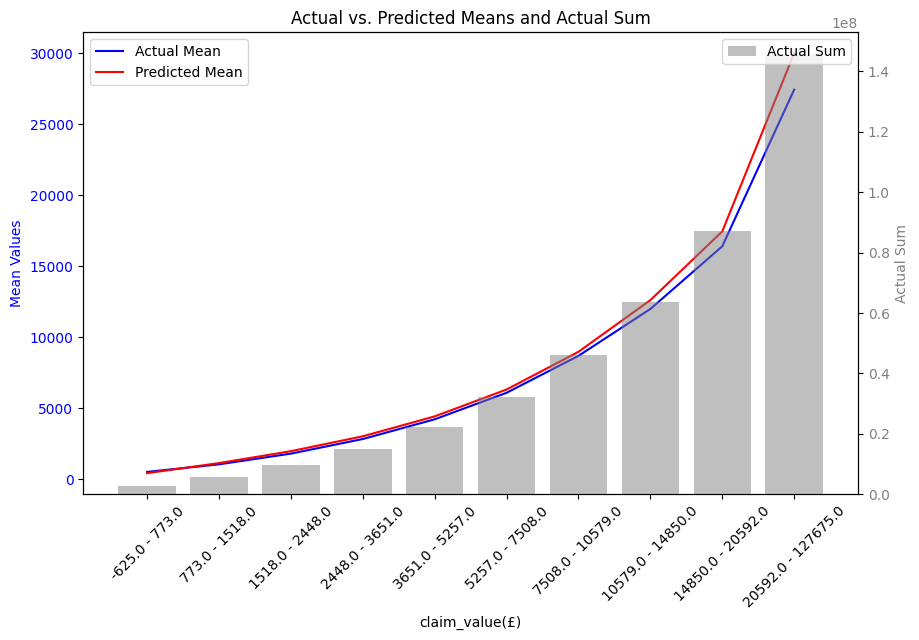

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot actual_mean and pred_mean on the primary y-axis
ax1.plot(decile_stats['bins'], decile_stats['actual_mean'], label='Actual Mean', color='blue')
ax1.plot(decile_stats['bins'], decile_stats['pred_mean'], label='Predicted Mean', color='red')
ax1.set_xlabel('claim_value(£)')
ax1.set_ylabel('Mean Values', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for actual_sum
ax2 = ax1.twinx()
#ax2.bar(decile_stats.index, decile_stats['actual_value'], color='grey', alpha=0.5, label='Actual Sum')

fig = ax2.bar(decile_stats['bins'], decile_stats['actual_value'], label='Actual Sum', color='gray', alpha=0.5)
ax2.set_ylabel('Actual Sum', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.legend(loc='upper right')
for item in ax1.get_xticklabels():
    item.set_rotation(45)


ax1.set_title('Actual vs. Predicted Means and Actual Sum')
plt.show()


#**Model Improvement Ideas**
* Get more features: speak with subject mattter experts to see features that are likely to be predictive
* Combine other company data sources
* Check for external data sources such as vehicle data providers (give more details about vehicles), postcode data (affluence/affordability measure)
* Model ensemble: Model could be ensembled with another model and we could use voting citeria to cover areas where the model is weak
* See if we could clip more features
* Increase the search space for model parameters, but this makes tuning slower
* Collect more data if you can
* Apply synthetic data

#**Model Implementation: Practical challenges**

Most common process is to deploy the model using API's.
Considerations:
* Best practice to log model and track experiments using tools like MLFlow
* Model registry: MLFLow also allows to manage the model lifecycle, like promote a model to staging and then production etc
* Is the use case Batch (non-real time and bulk scoring) or real-time.
* For real time, you need thing like:
*  load balancing
*  auto-scaling
* Build API's can be built using FastAPI, Django, Flask, Azure, AWS built-in functionality
* Front-end web interface to interact with API (send data to and from model)
* For Proof of Concept, one can use Streamlit, Gradio etc for web interface (built in python)
* Security considerations like authentication for logging in
* We need to consider things like impact analysis, are certain categories of customers unfairly impacted by the model.

##################################################################################################

In [ ]:
%%capture
#!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
#!apt-get install pandoc
#!jupyter nbconvert --to pdf '/content/drive/My Drive/Colab Notebooks/ayo_cinch_pricing.ipynb'